**Import modules and install Prophet**



In [2]:
from dateutil import parser
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np

!pip install pystan~=2.14
!pip install fbprophet

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly
from prophet.diagnostics import performance_metrics



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9536135 sha256=32e9346d4140ac6c8f0d24cf93085d8c2030f092656db2af51db2ab533cbd71a
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.1.0
    Uninstalling cmdstanpy-1.1.0:
      Successfully uninstalled cmdsta

**Read the data**

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('/content/gdrive/MyDrive/orders.csv', index_col=0)
df

Mounted at /content/gdrive


,_id,created_date,is_rain
0,61d0d1afd151a776242cbdae,2022-01-01 19:11:59.670,False
1,61d0d517d151a776242cbdb3,2022-01-01 19:26:31.641,False
2,61d0d780d151a776242cbdb5,2022-01-01 19:36:48.944,False
3,61d0d836d151a776242cbdb6,2022-01-01 19:39:50.540,False
4,61d0db3fd151a776242cbdb9,2022-01-01 19:52:47.506,False
...,...,...,...
94494,63af938298f942464d59fd83,2022-12-30 22:42:26.494,False
94495,63af951998f942464d5a000a,2022-12-30 22:49:13.613,False
94496,63af95b298f942464d5a00aa,2022-12-30 22:51:46.192,False
94497,63af962698f942464d5a0160,2022-12-30 22:53:42.423,False


**Prepare the data units for further processing**

In [4]:
df['created_date']=pd.to_datetime(df['created_date'])
df['is_rain']=df['is_rain'].astype(int)
df

,_id,created_date,is_rain
0,61d0d1afd151a776242cbdae,2022-01-01 19:11:59.670,0
1,61d0d517d151a776242cbdb3,2022-01-01 19:26:31.641,0
2,61d0d780d151a776242cbdb5,2022-01-01 19:36:48.944,0
3,61d0d836d151a776242cbdb6,2022-01-01 19:39:50.540,0
4,61d0db3fd151a776242cbdb9,2022-01-01 19:52:47.506,0
...,...,...,...
94494,63af938298f942464d59fd83,2022-12-30 22:42:26.494,0
94495,63af951998f942464d5a000a,2022-12-30 22:49:13.613,0
94496,63af95b298f942464d5a00aa,2022-12-30 22:51:46.192,0
94497,63af962698f942464d5a0160,2022-12-30 22:53:42.423,0


**Group the data by hour and use aggregation functions to determine if it rained during that hour and the number of orders per hour**

In [5]:
df['ds']=df['created_date'].dt.round('H')
df=df.groupby("ds").agg(
        y = ("_id", "count"),
        rain = ("is_rain", "max"))
df


,y,rain
ds,,
2022-01-01 19:00:00,2,0
2022-01-01 20:00:00,8,0
2022-01-01 21:00:00,17,0
2022-01-01 22:00:00,19,0
2022-01-01 23:00:00,10,0
...,...,...
2022-12-30 19:00:00,11,0
2022-12-30 20:00:00,24,0
2022-12-30 21:00:00,56,0


**Visualize the data**

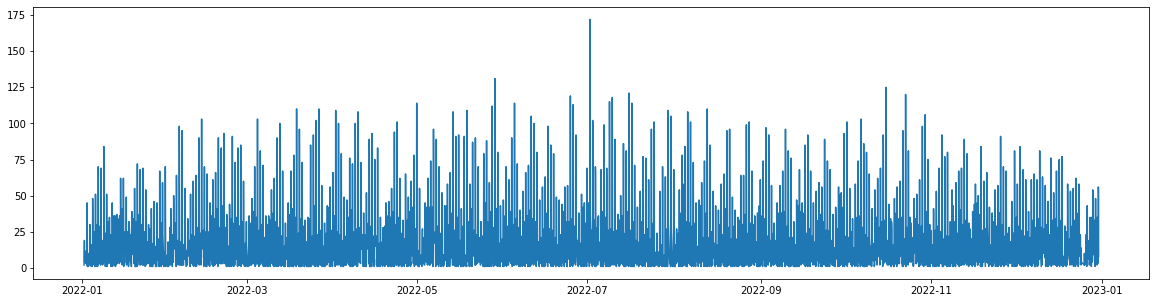

In [6]:
plt.plot(df['y'])

**Fill the missing hours with zero**

In [6]:

td=pd.Timedelta(1,"h")
iso = parser.parse('2022-01-01')
iso2 = parser.parse('2022-12-31')-td

full_hours = pd.date_range(start=iso, end=iso2, freq='H')

df=df.reindex(full_hours, fill_value=0)
df = df.reset_index()
df.rename(columns={'index':'ds'},inplace=True)
df

,ds,y,rain
0,2022-01-01 00:00:00,0,0
1,2022-01-01 01:00:00,0,0
2,2022-01-01 02:00:00,0,0
3,2022-01-01 03:00:00,0,0
4,2022-01-01 04:00:00,0,0
...,...,...,...
8731,2022-12-30 19:00:00,11,0
8732,2022-12-30 20:00:00,24,0
8733,2022-12-30 21:00:00,56,0
8734,2022-12-30 22:00:00,50,0


**Split the data into train and test**

In [8]:
month=30*24 
train=df.head(-month)
test=df.tail(month).reset_index(drop=True)
test

,ds,y,rain
0,2022-12-01 00:00:00,1,1
1,2022-12-01 01:00:00,0,0
2,2022-12-01 02:00:00,0,0
3,2022-12-01 03:00:00,0,0
4,2022-12-01 04:00:00,0,0
...,...,...,...
715,2022-12-30 19:00:00,11,0
716,2022-12-30 20:00:00,24,0
717,2022-12-30 21:00:00,56,0
718,2022-12-30 22:00:00,50,0


**Create a future dataframe that contains the dates for which predictions are to be made**

In [9]:

future_range=pd.date_range(start='2022-12-01 00:00', end='2022-12-30 23:00', freq='H')

future_dic = {
    'ds' : future_range,
    'y': np.zeros(shape=len(future_range)),
    'rain': np.zeros(shape=len(future_range))}
future=pd.DataFrame(future_dic)

**Initialize the model, fit and predict**

In [10]:

m = Prophet()
m.fit(train)
forecast = m.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x > 0 else 0)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat
0,2022-12-01 00:00:00,4.556601
1,2022-12-01 01:00:00,0.000000
2,2022-12-01 02:00:00,0.000000
3,2022-12-01 03:00:00,0.502430
4,2022-12-01 04:00:00,3.586296
...,...,...
715,2022-12-30 19:00:00,24.825072
716,2022-12-30 20:00:00,45.454309
717,2022-12-30 21:00:00,54.763494
718,2022-12-30 22:00:00,47.127780


**Plot trend and seasonality**

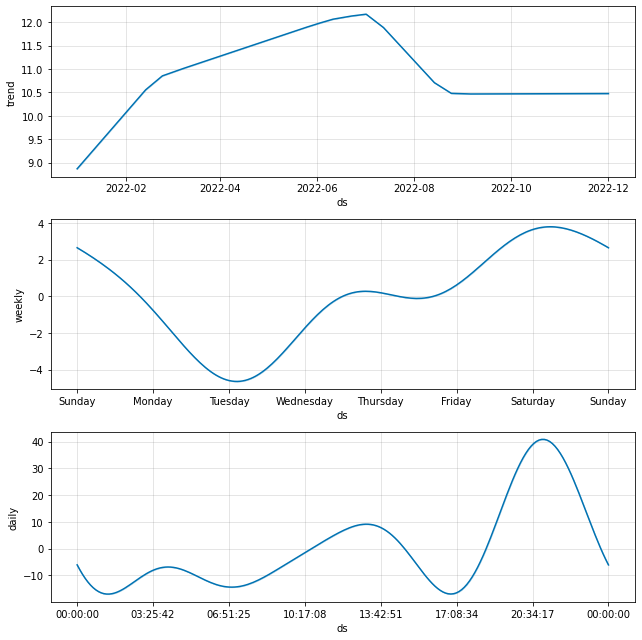

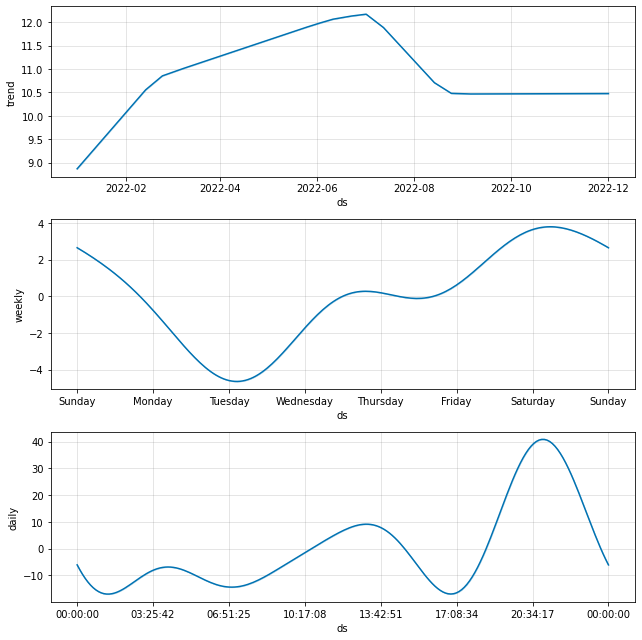

In [11]:
forecast_train = m.predict(train)
m.plot_components(forecast_train)

**Create a DataFrame that includes only the hours during which the service is available**

In [25]:
hours=pd.date_range(start='11:00', end='23:00', freq='H').strftime('%H:%M:%S')
df_hours = pd.DataFrame (hours, columns = ['hour']) 
df_hours['hour'] = df_hours['hour'].apply(lambda x: datetime.strptime(x, "%H:%M:%S").time())



hour    object
dtype: object

**Calculate the MAE using only the hours during which the service is available**

In [28]:
t=test
t['hour']=t['ds'].dt.time
t= t[t['hour'].isin(df_hours['hour'])]  

f=forecast
f['hour']=f['ds'].dt.time
f = f[f['hour'].isin(df_hours['hour'])]

y_true = t['y'].values
y_pred = f['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

MAE: 8.414155259743305


**Plot the prediction and the actual demand**

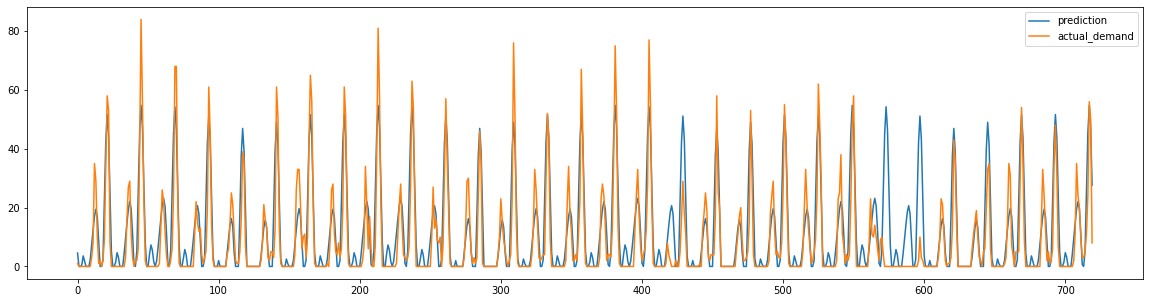

In [29]:
forecast['actual_demand']=test['y']
forecast.rename(columns={'yhat':'prediction'},inplace=True)
forecast.plot(kind = "line", y = ['prediction' ,'actual_demand'])

**Cross-validation**

In [30]:
forecast_cv = cross_validation(m, initial = '90 days', period='30 days',
                               horizon='30 days', parallel='processes')
metrics = performance_metrics(forecast_cv)
metrics.mean()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2022-04-04 23:00:00 and 2022-10-31 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd0bd303490>
INFO:prophet:Skipping MAPE because y close to 0


horizon     16 days 12:00:00
mse                98.205595
rmse                9.890417
mae                 6.677625
mdape               2.873686
smape               1.255604
coverage            0.863462
dtype: object

**Repeat the process, changing the order of daily seasonality**

In [31]:
m = Prophet(daily_seasonality=24)
m.fit(train)
forecast = m.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x > 0 else 0)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [32]:
   
f=forecast
f['hour']=f['ds'].dt.time
f = f[f['hour'].isin(df_hours['hour'])]
y_pred = f['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

MAE: 6.565364118139884


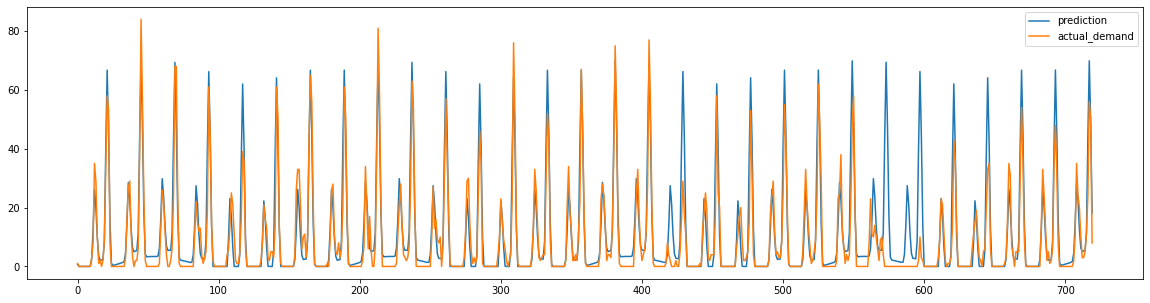

In [33]:
forecast['actual_demand']=test['y']
forecast.rename(columns={'yhat':'prediction'},inplace=True)
forecast.plot(kind = "line", y = ['prediction' ,'actual_demand'])

In [34]:
forecast_cv = cross_validation(m, initial = '90 days', period='30 days',
                               horizon='30 days', parallel='processes')
metrics = performance_metrics(forecast_cv)
metrics.mean()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2022-04-04 23:00:00 and 2022-10-31 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd0b89aa640>
INFO:prophet:Skipping MAPE because y close to 0


horizon     16 days 12:00:00
mse                59.667798
rmse                7.685873
mae                 4.617917
mdape               1.475825
smape               1.146559
coverage            0.893568
dtype: object

**Repeat the process adding "rain" regressor**


In [35]:
m = Prophet(daily_seasonality=24)
m.add_regressor('rain')
m.fit(train)
forecast = m.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: x if x > 0 else 0)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [36]:
f=forecast
f['hour']=f['ds'].dt.time
f = f[f['hour'].isin(df_hours['hour'])]
y_pred = f['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

MAE: 6.536011626216463


In [37]:
forecast_cv = cross_validation(m, initial = '90 days', period='30 days',
                               horizon='30 days', parallel='processes')
metrics = performance_metrics(forecast_cv)
metrics.mean()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2022-04-04 23:00:00 and 2022-10-31 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fd0a139edc0>
INFO:prophet:Skipping MAPE because y close to 0


horizon     16 days 12:00:00
mse                59.200547
rmse                7.657902
mae                 4.593131
mdape                1.47576
smape               1.146529
coverage             0.89368
dtype: object